Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 173, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 173, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 173, 1)         │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,160 (67.03 KB)

 Trainable params: 17,160 (67.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.2018 - val_loss: 0.0721
Epoch 2/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - loss: 0.0710 - val_loss: 0.0694
Epoch 3/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - loss: 0.0695 - val_loss: 0.0693
Epoch 4/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - loss: 0.0694 - val_loss: 0.0693
Epoch 5/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.0694 - val_loss: 0.0693
Epoch 6/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - loss: 0.0694 - val_loss: 0.0693
Epoch 7/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - loss: 0.0694 - val_loss: 0.0693
Epoch 8/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - loss: 0.0694 - val_loss: 0.0693
Epoch 9/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - loss: 0.0694 - val_loss: 0.0693
Epoch 10/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - loss: 0.0694 - val_loss: 0.0693
Epoch 11/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 553669.0000 - val_loss: 0.0706
Epoch 12/20
668/668 ━━━━━

/var/folders/mr/191vzwfd1d33jdpry4l7m91m0000gn/T/ipykernel_6407/929683918.py:103: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


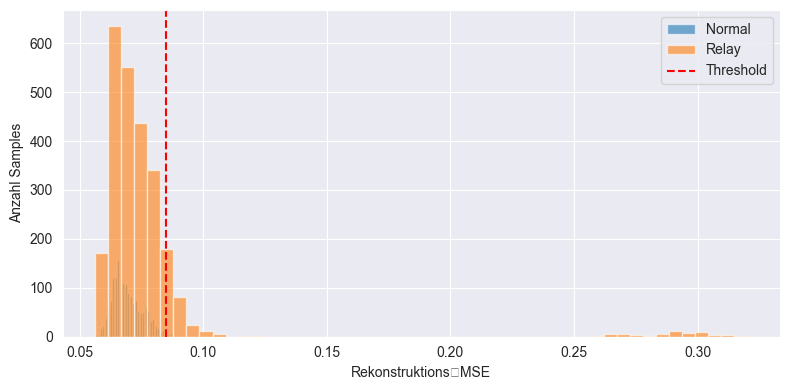

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector

# --- 1. Daten laden und skalieren (dein Original-Code) ---
normal_path = "features/S01/1/Normal/c_data"
relay_path  = "features/S01/1/Relay/c_data"

with h5py.File("datasets/features_S01_combined.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49997, n_norm))
    dataset_relay  = np.zeros((49998, n_relay))

    for i in range(49997):
        try:
            dataset_normal[i] = normal_group[str(i)][:]
        except KeyError:
            continue

    for i in range(49998):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

# Splitten
X_train       = dataset_normal[:47500]
X_test_norm   = dataset_normal[47500:]
X_test_relay  = dataset_relay[47500:]
y_true        = np.array([0]*len(X_test_norm) + [1]*len(X_test_relay))

# Skalieren
scaler = MinMaxScaler().fit(X_train)
X_train_scaled      = scaler.transform(X_train)
X_test_norm_scaled  = scaler.transform(X_test_norm)
X_test_relay_scaled = scaler.transform(X_test_relay)
X_test_combined     = np.vstack((X_test_norm, X_test_relay))
X_test_scaled       = np.vstack((X_test_norm_scaled, X_test_relay_scaled))

# --- 2. Für LSTM umformen: (Samples, Timesteps, Features) ---
# Hier behandeln wir jede Zeile als Zeitreihe mit n_norm Zeitschritten und 1 Feature
timesteps = X_train_scaled.shape[1]
X_train_r  = X_train_scaled.reshape(-1, timesteps, 1)
X_test_r   = X_test_scaled.reshape(-1, timesteps, 1)

# --- 3. LSTM-Autoencoder modellieren ---
input_dim = 1

inputs  = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu')(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, activation='relu', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# --- 4. Trainieren ---
history = autoencoder.fit(
    X_train_r, X_train_r,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

# --- 5. Threshold anhand der Trainings-Rekonstruktionsfehler bestimmen ---
X_train_pred = autoencoder.predict(X_train_r)
train_mse = np.mean((X_train_r - X_train_pred)**2, axis=(1,2))
threshold = np.percentile(train_mse, 99)
print(f"Schwellwert (95. Perzentil): {threshold:.5f}")

# --- 6. Auf Testdaten anwenden und evaluieren ---
X_test_pred = autoencoder.predict(X_test_r)
test_mse    = np.mean((X_test_r - X_test_pred)**2, axis=(1,2))
y_pred      = (test_mse > threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

# --- 7. Visualisierung der Fehlerverteilung ---
plt.figure(figsize=(8,4))
plt.hist(test_mse[y_true==0], bins=50, alpha=0.6, label='Normal')
plt.hist(test_mse[y_true==1], bins=50, alpha=0.6, label='Relay')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel("Rekonstruktions‐MSE")
plt.ylabel("Anzahl Samples")
plt.legend()
plt.tight_layout()
plt.show()
